In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

# 1. upload data sets, and convert to pandas data frames
country_stats_data = pd.read_csv("country_happiness_report.csv")
all_int_football_results = pd.read_csv("all_int_football_results.csv")
historic_wc_top_three = pd.read_csv("historical_world_cup_top_three.csv")
fifa_players_data = pd.read_csv("fifa_players.csv")

# 2. clean data.
# replace missing values by mean of set, given attribute and data set.
# replace missing values by mode of set, given attribute and data set.
# given attrs to keep in the set, trim set.
# aggregate to provide clarity when relevant
# organize existing data into meaningful data frames.


In [2]:
# extra dataset not yet needed
# TODO: delete this if we won't use it.
# historic_wc_games_data = pd.read_csv("historical_world_cup_final_bracket_games.csv")

# Data Cleaning, Massaging, and Merging

In [3]:
# fifa_players_data
# data cleaning
# minimize attributes used.
# fill national team based on nationality if value is null.
# fill numeric missing values with mean.
# fill categorical missing values with mode.
# normalize attribute values that are numeric for consistency in correlation
# sort players by overall rating.
top_player_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'positions',
    'value_euro',
    'wage_euro',
    'preferred_foot',
    'international_reputation(1-5)',
    'body_type',
    'national_team', # use nationality if na
]
top_player_fill_mean_attrs = [
    'overall_rating',
    'value_euro',
    'wage_euro',
    'international_reputation(1-5)',
]
top_player_fill_mode_attrs = [
    'preferred_foot',
    'body_type',
]

selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_attrs]
fifa_top_players_data = fifa_players_data[selected_attrs_cols]
fifa_top_players_data['national_team'] = fifa_players_data.national_team.fillna(fifa_top_players_data['nationality'])
# data cleaning - fill by means and modes based on attr set.
fifa_top_players_data[top_player_fill_mean_attrs] = fifa_top_players_data[top_player_fill_mean_attrs].transform(lambda x: x.fillna(x.mean()))
fifa_top_players_data[top_player_fill_mode_attrs] = fifa_top_players_data[top_player_fill_mode_attrs].transform(lambda x: x.fillna(x.mode()))

# normalize numeric attr values
top_player_subset_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
# create a subset data table for player skills
top_player_skill_attrs = [attr for attr in top_player_subset_attrs if attr is not 'full_name' and attr is not 'nationality' ]
selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_subset_attrs]

fifa_top_players_skills_data = fifa_players_data[selected_attrs_cols]
# normalize
fifa_top_players_skills_data[top_player_skill_attrs] = fifa_top_players_skills_data[top_player_skill_attrs].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
# fifa_top_players_data
fifa_top_players_skills_data.sort_values(by=['overall_rating'], inplace=True, ascending=False)
# fifa_top_players_skills_data.head()

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

World Cup Historical Performance Summary

In [37]:
# historic_wc_top_three
# organize historical world cup data by country
# aggregate records in terms of number of times finishing in a given place in final four
# fill na with 0
# add column for sum of total QF appearances
# rename some columns so there is clearly First, Second, Third, Fourth 

finishes = ['Winner', 'Runners-Up', 'Third', 'Fourth']

wc_hist_perf_summary = pd.DataFrame(data=historic_wc_top_three['Country'])
for finish in finishes:
    temp_sum = pd.DataFrame()
    temp_sum[finish] = historic_wc_top_three[finish].value_counts()
    temp_sum = temp_sum.rename_axis('Country')
    temp_sum['Country'] = temp_sum.index
    temp_sum.index.rename('test')
    wc_hist_perf_summary = pd.merge(wc_hist_perf_summary,temp_sum, how='left', on="Country", left_index=False, right_index=False)

wc_hist_perf_summary[finishes] = wc_hist_perf_summary[finishes].transform(lambda x: x.fillna(0)).transform(lambda x: x.astype(int))
wc_hist_perf_summary['Sum QF Appearances'] = wc_hist_perf_summary.sum(axis=1)
wc_hist_perf_summary = wc_hist_perf_summary.rename(columns={'Runners-Up': 'Second', 'Winner': 'First'})
wc_hist_perf_summary.head()

,Country,First,Second,Third,Fourth,Sum QF Appearances
0,Uruguay,2,0,0,3,5
1,Italy,4,2,1,1,8
2,France,1,1,2,1,5
3,Brazil,5,2,2,2,11
4,Switzerland,0,0,0,0,0


Country's Top Finishes in Quarter Finals

In [39]:
# aggregate top finishes for each country using aggregated data on qf finishes (only including qf finishes)
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']

def find_top_finish_in_qf(row):
    # print(row['Country'])
    country = row['Country']
    finishes = wc_hist_perf_summary.loc[wc_hist_perf_summary['Country'] == country]
    top_finish = 0
    first = (finishes.First).all()
    second = (finishes.Second).all()
    third = (finishes.Third).all()
    fourth = (finishes.Fourth).all()
    if (first):
        top_finish = 1
    elif (second):
        top_finish = 2
    elif (third):
        top_finish = 3
    elif (fourth):
        top_finish = 4
    return top_finish

top_finishes_in_qf = pd.DataFrame(data=wc_hist_perf_summary['Country'])
top_finishes_in_qf['top finish'] = top_finishes_in_qf.apply(lambda x: find_top_finish_in_qf(x), axis=1)
top_finishes_in_qf.head()

,Country,top finish
0,Uruguay,1
1,Italy,1
2,France,1
3,Brazil,1
4,Switzerland,0


Country Stats by Country

In [100]:
# minimize, clean, and aggregate country happiness data
# minimize number of attributes in set
# select a number of years for each country using broundaries.
# TODO: add a row for a year not present based on mean.
# find the mean for each country
# TODO: remove years column
# for data with NAN values, data was NaN for all values in country.  Update with mean from column.
selected_attrs_country = [
    'country',
    'year', 
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

attrs_for_cleaning_nans = [
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

# minimize data set
selected_attrs_cols = [col for col in country_stats_data.columns if col in selected_attrs_country]
country_data = country_stats_data[selected_attrs_cols]

# set date boundaries 
start_remove = 2014
end_remove = 2016
# group data by country and use mean for group override NAN with mean.
for attr in attrs_for_cleaning_nans:
    country_data[attr] = country_data.groupby('country', as_index=False)[attr].transform(lambda x: x.fillna(x.mean()))

# filter for years in boundaries
country_data = country_data.loc[(country_data.year >= start_remove) & (country_data.year <= end_remove)]
# get mean for country over years
country_data = country_data.groupby('country', as_index=False)[selected_attrs_cols].mean()
# remaining NaNs are because data was NaN for all values in country.  replace these with mean from column.
country_data = country_data.fillna(country_data.mean())
country_data.head()


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,Afghanistan,2015.0,3.777973,7.507917,0.537746,49.588539,0.473336,0.090321,0.550066,0.354156,0.331531,-1.895385,0.281074
1,Albania,2015.0,4.643838,9.251357,0.634452,68.531487,0.722773,-0.041561,0.682841,0.335558,0.468892,0.116744,0.126247
2,Algeria,2015.0,5.871535,9.531784,0.783170,64.624016,0.569640,-0.212148,0.647371,0.274119,0.472700,-1.085674,0.233018
3,Angola,2014.0,3.794838,8.847354,0.754615,45.092995,0.374542,-0.164495,0.578517,0.367864,0.572346,-0.705554,0.233018
4,Argentina,2015.0,6.598489,9.658498,0.909061,67.291908,0.824661,-0.131493,0.852525,0.284971,0.402231,0.166956,0.199123


Total Wins By Country in 2018 World Cup Matches

In [44]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_2018 = fifa_wc_results.loc[all_int_football_results['date'].str.contains('2018')]

def find_winner(row):
    if row.home_score > row.away_score:
        return row.home_team
    elif row.home_score < row.away_score:
        return row.away_team
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_2018['winner'] = fifa_wc_results_2018.apply(lambda row: find_winner(row), axis=1)
fifa_wc_results_2018_winners = fifa_wc_results_2018.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
#fifa_wc_results_2018
fifa_wc_results_2018_winners = pd.DataFrame(fifa_wc_results_2018_winners)
fifa_wc_results_2018_winners = fifa_wc_results_2018_winners[fifa_wc_results_2018_winners.winner != 'tie']
fifa_wc_results_2018_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
fifa_wc_results_2018_winners.head()


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,winner,num_wins
1,Belgium,6
7,France,6
25,Uruguay,4
4,Croatia,4
22,Sweden,3


Fifa World Cup Winners as Historical Sum by Country

In [45]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_all_time = fifa_wc_results

def find_winner(row):
    if row.home_score > row.away_score:
        return row.home_team
    elif row.home_score < row.away_score:
        return row.away_team
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_all_time['winner'] = fifa_wc_results_all_time.apply(lambda row: find_winner(row), axis=1)
fifa_wc_results_all_time_winners = fifa_wc_results_all_time.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
#fifa_wc_results_2018
fifa_wc_results_all_time_winners = pd.DataFrame(fifa_wc_results_all_time_winners)
fifa_wc_results_all_time_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
fifa_wc_results_all_time_winners.head()

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,winner,num_wins
62,tie,199
6,Brazil,73
21,Germany,67
26,Italy,45
1,Argentina,43


# Cleaned Datasets

In [96]:
# datasets
# top players skills, in order of rank.
fifa_top_players_skills_data.head()
# world cup performance summary for each country, showing number of times they finished in the top four and sum of 
# all qf appearances, historically.
wc_hist_perf_summary.head()
# top finish for a country who has played in a WC quarter final match.
top_finishes_in_qf.head()
# country data happiness
country_data.head()
# 2018 wc number of wins for top countries (excluding 2018)
fifa_wc_results_2018_winners.head()
# total number of matches won by each countries in all world cups, historically (excluding 2018)

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,Afghanistan,2015.0,3.777973,7.507917,0.537746,49.588539,0.473336,0.090321,0.550066,0.354156,0.331531,-1.895385,0.281074
1,Albania,2015.0,4.643838,9.251357,0.634452,68.531487,0.722773,-0.041561,0.682841,0.335558,0.468892,0.116744,0.126247
2,Algeria,2015.0,5.871535,9.531784,0.783170,64.624016,0.569640,-0.212148,0.647371,0.274119,0.472700,-1.085674,0.233018
3,Angola,2014.0,3.794838,8.847354,0.754615,45.092995,0.374542,-0.164495,0.578517,0.367864,0.572346,-0.705554,0.233018
4,Argentina,2015.0,6.598489,9.658498,0.909061,67.291908,0.824661,-0.131493,0.852525,0.284971,0.402231,0.166956,0.199123


# Merge Datasets for Analysis

In [48]:
# join simple soccer 2018 wc wins and country data set
merged_2018_wc_wins_and_happiness_by_country = pd.merge(left=fifa_wc_results_2018_winners,right=country_data, left_on='winner', right_on='country')
m_a_h_c_2018 = merged_2018_wc_wins_and_happiness_by_country.drop(['winner'], axis=1)
m_a_h_c_2018 = m_a_h_c_2018.rename(columns={"num_wins": "total wc wins of country"})
merged_2018_wc_wins_and_happiness_by_country = m_a_h_c_2018
m_a_h_c_2018.head()
# merged_2018_wc_wins_and_happiness_by_country = m_a_h_c_2018

,total wc wins of country,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,6,Belgium,2015.0,6.902828,10.624256,0.919241,71.521675,0.865396,-0.006026,0.789134,0.250390,0.449104,1.075157,0.306121
1,6,France,2015.0,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650
2,4,Uruguay,2015.0,6.453670,9.900286,0.897924,68.120193,0.902528,-0.072871,0.867820,0.278072,0.523013,0.990709,0.277648
3,4,Croatia,2014.5,5.293065,9.914950,0.707031,67.503502,0.606201,0.013581,0.602532,0.289957,0.259938,0.538784,0.206280
4,3,Sweden,2015.0,7.298938,10.718898,0.924747,71.961449,0.932794,0.172794,0.823103,0.199762,0.516122,1.371415,0.562753


In [12]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.
fifa_wc_winners_and_country_happiness = pd.merge(left=fifa_wc_results_all_time_winners,right=country_data, left_on='winner', right_on='country')
fifa_wc_winners_and_country_happiness = fifa_wc_winners_and_country_happiness.drop(['year', 'winner'], axis=1)
# fifa_wc_winners_and_country_happiness.head()

In [58]:
top_finishes_in_qf.head()

,Country,top finish
0,Uruguay,1
1,Italy,1
2,France,1
3,Brazil,1
4,Switzerland,0


In [61]:
top_wc_finishes_and_country_happiness = pd.merge(left=top_finishes_in_qf,right=country_data, left_on='Country', right_on='country')
top_wc_finishes_and_country_happiness = top_wc_finishes_and_country_happiness.drop(['year', 'Country'], axis=1)
top_wc_finishes_and_country_happiness.head()

,top finish,country,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,1,Uruguay,6.453670,9.900286,0.897924,68.120193,0.902528,-0.072871,0.867820,0.278072,0.523013,0.990709,0.277648
1,1,Italy,5.942931,10.422762,0.911366,72.727562,0.607346,-0.076797,0.697753,0.341467,0.269087,0.730997,0.207117
2,1,Italy,5.942931,10.422762,0.911366,72.727562,0.607346,-0.076797,0.697753,0.341467,0.269087,0.730997,0.207117
3,1,France,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650
4,1,France,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650


In [13]:
fifa_top_players_skills_and_country_happiness = pd.merge(left=fifa_top_players_skills_data,right=country_data, left_on='nationality', right_on='country')

f_t_p_s_c_h_a_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_and_country_happiness, left_on='winner', right_on='country')
f_t_p_s_c_h_a_wins = f_t_p_s_c_h_a_wins.drop(['winner'], axis=1)
fifa_top_players_skills_and_country_happiness = f_t_p_s_c_h_a_wins.rename(columns={"num_wins": "wc_wins_for_country"})
# fifa_top_players_skills_and_country_happiness.head()

In [77]:
fifa_wc_results_2018_winners.head()

,winner,num_wins
1,Belgium,6
7,France,6
25,Uruguay,4
4,Croatia,4
22,Sweden,3


In [112]:
x = fifa_top_players_skills_and_country_happiness.groupby('country').mean()
a = pd.merge(left=x, right=fifa_wc_results_2018_winners, left_on='country', right_on='winner')
#a = a.drop(['winner'], axis=1)
a = a.rename(columns={'num_wins': 'wc_wins_in_2018', 'overall_rating': 'overall_player_rating', 'winner': 'country'})
a.sort_values(by=['overall_player_rating'], inplace=True, ascending=False)
attrs_for_removal = [
    'full_name',
    'nationality',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
selected_attrs = [
    'country',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'wc_wins_for_country',
    'overall_player_rating',
    'wc_wins_in_2018',
]
a = a.drop(['year'], axis=1)
un_selected_attrs = [col for col in a.columns if col not in attrs_for_removal]
un_selected_attrs = [col for col in a.columns if col not in attrs_for_removal]
country_happiness_player_summary_and_wc_performance_by_country = a[un_selected_attrs]
complete_player_data_and_wc_performance_by_country = a[selected_attrs]


,country,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,freekick_accuracy,long_passing,...,agility,reactions,shot_power,jumping,stamina,strength,long_shots,wc_wins_for_country,overall_player_rating,wc_wins_in_2018
14,Portugal,0.583379,0.504381,0.561227,0.662270,0.525751,0.629241,0.570217,0.499032,0.582907,...,0.672766,0.616169,0.656171,0.638433,0.629570,0.576662,0.544957,14,0.513052,1
2,Brazil,0.559550,0.517021,0.591947,0.651568,0.532341,0.603882,0.529556,0.511557,0.568696,...,0.633272,0.613114,0.632754,0.620658,0.626654,0.611748,0.551973,73,0.511738,3
23,Uruguay,0.540909,0.504022,0.595638,0.642550,0.494764,0.587256,0.514815,0.496215,0.563757,...,0.628410,0.584053,0.623656,0.642500,0.629542,0.612602,0.536752,24,0.505280,4
12,Peru,0.561237,0.514636,0.575926,0.649871,0.522350,0.612306,0.520518,0.494505,0.588955,...,0.672876,0.564043,0.632318,0.642014,0.620915,0.539322,0.543956,5,0.496454,1
18,Serbia,0.546322,0.494295,0.607125,0.645216,0.505221,0.585406,0.520559,0.480497,0.565158,...,0.572160,0.573685,0.637446,0.619561,0.617961,0.667195,0.547437,4,0.490011,1
15,Russia,0.502622,0.477392,0.520370,0.611956,0.448423,0.536256,0.444930,0.440688,0.542430,...,0.569080,0.571759,0.572236,0.600160,0.579638,0.577922,0.483657,19,0.484997,2
4,Croatia,0.519908,0.482901,0.591395,0.633153,0.474808,0.570135,0.474368,0.452698,0.553795,...,0.575321,0.564745,0.595198,0.590508,0.606103,0.644175,0.504834,11,0.481843,4
19,Spain,0.563063,0.501548,0.548463,0.656390,0.477022,0.581881,0.531531,0.483198,0.571518,...,0.624409,0.576116,0.602140,0.623353,0.604882,0.565457,0.516175,30,0.481169,1
8,Iran,0.587662,0.565284,0.563492,0.645349,0.555008,0.632104,0.539773,0.509419,0.491497,...,0.683193,0.578373,0.650538,0.614286,0.624370,0.540816,0.579278,2,0.474164,1
0,Argentina,0.528082,0.493946,0.567355,0.621025,0.480457,0.582881,0.488310,0.461818,0.540126,...,0.627876,0.565189,0.598880,0.637099,0.613600,0.589659,0.515013,43,0.461001,1


# Joint Dataset Subsets

In [62]:
# players
players_2018_wc_wins = pd.merge(left=fifa_wc_results_2018_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
players_alltime_country_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
complete_player_data_and_wc_performance_by_country

# countries
wc_hist_perf_summary
top_finishes_in_qf
fifa_wc_results_all_time_winners

# country happiness
fifa_wc_winners_and_country_happiness
merged_2018_wc_wins_and_happiness_by_country
country_happiness_player_summary_and_wc_performance_by_country

# assorted
fifa_top_players_skills_and_country_happiness.head()

# missing
# country happiness and top finishes in qf
# country happiness and top ranked players


,wc_wins_for_country,full_name,nationality,overall_rating,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,73,Neymar da Silva Santos Junior,Brazil,0.957447,0.886364,0.913978,0.644444,0.895349,0.931034,0.989247,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
1,73,Philippe Coutinho Correia,Brazil,0.872340,0.840909,0.827957,0.488889,0.930233,0.827586,0.935484,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
2,73,Thiago Emiliano da Silva,Brazil,0.872340,0.625000,0.387097,0.855556,0.848837,0.689655,0.623656,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
3,73,Carlos Henrique Venancio Casimiro,Brazil,0.851064,0.602273,0.666667,0.800000,0.883721,0.666667,0.698925,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
4,73,Marcelo Vieira da Silva Júnior,Brazil,0.851064,0.965909,0.763441,0.788889,0.895349,0.666667,0.924731,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043


# My Selections for Analysis

In [ ]:
# players_2018_wc_wins
# fifa_wc_winners_and_country_happiness
# top_wc_finishes_and_country_happiness
country_happiness_player_summary_and_wc_performance_by_country
complete_player_data_and_wc_performance_by_country

In [15]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.

In [16]:
# If you have a lot of variables, you can use the pandas.DataFrame method corr() 
# to calculate a correlation matrix that shows the correlation coefficient for each pair of variables.
# correlated_fifa_winners_and_national_happiness
def create_correlation_heatmap(dataset, show_corr_nums):
    c_f_w_a_n_p = dataset.corr()
    mask = np.zeros_like(c_f_w_a_n_p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(13, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(c_f_w_a_n_p, vmax=1., annot=show_corr_nums, mask=mask, linewidths=.5, cmap="viridis")
    
#create_correlation_heatmap(fifa_wc_winners_and_country_happiness, True)
#create_correlation_heatmap(fifa_top_players_skills_and_country_happiness, False)


In [17]:
import scipy.stats
def log_correlation_to_wins(dataframe, comparison_attr, comparison_set):
    my_panda = pd.DataFrame()
    for attr in comparison_set:
        x = dataframe[comparison_attr]
        y = dataframe[attr]
        z = scipy.stats.pearsonr(x.values,y.values)[0]

        a = y.corr(x)
        my_panda.at[attr, 'Pearsons'] = z
        my_panda.at[attr, 'Corr'] = a

    my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
    return my_panda

skills = [
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
]

def log_correlation_multi(dataframe):
    my_panda = pd.DataFrame()
    for hap_attr in attrs_for_cleaning_nans:
        for plyr_skill in skills:
            x = dataframe[plyr_skill]
            y = dataframe[hap_attr]
            z = scipy.stats.pearsonr(x.values,y.values)[0]

            a = y.corr(x)
            row_name = plyr_skill + ', ' + hap_attr
            my_panda.at[row_name, 'Pearsons'] = z
            my_panda.at[row_name, 'Corr'] = a

    my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
    return my_panda

#log_correlation_to_wins(fifa_wc_winners_and_country_happiness, 'num_wins', attrs_for_cleaning_nans)

In [18]:

#log_correlation_multi(fifa_top_players_skills_and_country_happiness)

In [19]:
#log_correlation_to_wins(fifa_top_players_skills_and_country_happiness, 'wc_wins_for_country', skills)

In [20]:
# group things with top ranked countries into sets to find similarities.
#fifa_top_players_skills_and_country_happiness.head()

In [21]:
# fifa_top_players_skills_and_country_happiness.head()
# a = fifa_top_players_skills_and_country_happiness
# a.head()
# y = a['overall_rating'].mean()
# b = df1 = a[a['overall_rating'].astype(float) > y]
def filter_for_significance(pandaset, include_only_wins, filter_name):
    dataset_list = []
    for index, row in pandaset.iterrows(): 
        dataset_row = []
        is_winning_country = False
        for col in pandaset.columns:
            if type(row[col]) is float or type(row[col]) is int:
                col_mean = pandaset[col].mean()
                if row[col] > col_mean:
                    if (col is filter_name):
                        is_winning_country = True
                    dataset_row.append(col)
        if include_only_wins:
            if is_winning_country is True:
                dataset_list.append(dataset_row)
        else:
            dataset_list.append(dataset_row)
    return dataset_list

def set_up_for_apriori(data_list):
    te = TransactionEncoder()
    te_ary = te.fit(data_list).transform(data_list)
    return pd.DataFrame(te_ary, columns=te.columns_)


In [22]:
a = fifa_top_players_skills_and_country_happiness

In [23]:
significance_including_only_winners = set_up_for_apriori(filter_for_significance(a, True, 'wc_wins_for_country'))

In [24]:
# significance_including_only_winners.head()

In [25]:
significance_no_required_attr_in_set = set_up_for_apriori(filter_for_significance(a, False, 'wc_wins_for_country'))

In [26]:
# significance_no_required_attr_in_set.head()

In [27]:
# def set_apriori_w_threshold_support(data_list):
#     pd.set_option('display.max_colwidth', -1)
#     frequent_itemsets = apriori(data_list, use_colnames=True)
#     return frequent_itemsets

def filter_for_consequents(data_list, consequent, antecendent_min_len, confidence_min, support_min, lift_min):
    #association_set = association_set[association_set['consequents'].astype(str).str.contains(consequent)]
    pd.set_option('display.max_colwidth', -1)
    freq_itemsets = apriori(data_list, use_colnames=True)
    association_set = association_rules(freq_itemsets, metric="lift", min_threshold=0, support_only=False)
    association_set["antecedent_len"] = association_set["antecedents"].apply(lambda x: len(x))
    association_set = association_set[(association_set['antecedent_len'] >= antecendent_min_len) &
       (association_set['consequents'].astype(str).str.contains(consequent)) &
       (association_set['confidence'] > confidence_min) &
       (association_set['support'] > support_min) &                              
       (association_set['lift'] > lift_min)]
    return association_set


In [28]:
#s_1_frequent_itemsets = set_apriori_w_threshold_support(significance_including_only_winners, .5)
#association_set = association_rules(s_1_frequent_itemsets, metric="lift", min_threshold=0.5, support_only=False)
assoc_rules = filter_for_consequents(
    significance_including_only_winners, 
    # consequent = #
    'wc_wins_for_country', 
    # antecendent_min_len = #
    3, 
    # min support threshold = #,
    .5,
    # confidence_min = #
    0, 
    # lift_min = #
    1)
assoc_rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
1193,"(Healthy life expectancy at birth, Log GDP per capita, Social support)","(Democratic Quality, wc_wins_for_country)",0.558414,0.711915,0.558414,1.0,1.404662,0.160871,inf,3
1194,"(Democratic Quality, Log GDP per capita, Social support)","(Healthy life expectancy at birth, wc_wins_for_country)",0.558414,0.711915,0.558414,1.0,1.404662,0.160871,inf,3
1198,"(Healthy life expectancy at birth, Democratic Quality, Social support)","(Log GDP per capita, wc_wins_for_country)",0.558414,0.711915,0.558414,1.0,1.404662,0.160871,inf,3
1223,"(Healthy life expectancy at birth, ball_control, Log GDP per capita)","(Democratic Quality, wc_wins_for_country)",0.500996,0.711915,0.500996,1.0,1.404662,0.144329,inf,3
1224,"(Democratic Quality, Log GDP per capita, ball_control)","(Healthy life expectancy at birth, wc_wins_for_country)",0.500996,0.711915,0.500996,1.0,1.404662,0.144329,inf,3


In [29]:
# s_2_frequent_itemsets = set_apriori_w_threshold_support(
#     significance_no_secondary_filter)
# association_set_2 = association_rules(s_2_frequent_itemsets, metric="lift", min_threshold=0.5, support_only=False)

x = filter_for_consequents(
    significance_no_required_attr_in_set, 
    # consequent = #
    'dribbling', 
    # antecendent_min_len = #
    0, 
    # min support threshold = #,
    0,
    # confidence_min = #
    0, 
    # lift_min = #
    0)
x.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
18,(acceleration),(dribbling),0.604412,0.658746,0.526612,0.871280,1.322634,0.128458,2.651131,1
22,(agility),(dribbling),0.562662,0.658746,0.505589,0.898566,1.364055,0.134938,3.364295,1
26,(ball_control),(dribbling),0.666963,0.658746,0.608187,0.911876,1.384260,0.168828,3.872416,1
40,(crossing),(dribbling),0.579466,0.658746,0.526020,0.907767,1.378023,0.144299,3.699912,1
42,(finishing),(dribbling),0.540380,0.658746,0.502480,0.929863,1.411565,0.146506,4.865535,1


In [30]:
# TODO Filter set for only correlated attributes

In [31]:
# classification.
# Decision Trees and Bayesian Classifier
# merge 2018 WC wins into player dataset.
# look at num_wins in country happiness data
# look at num_wins in player dataset.
# run classification algorithms.
# what characteristics determine win.
# x should be data, y target.
# TODO: can use classifiers instead of float/regression

In [32]:
def setUpDataForClassification(data_set, target_column, classified_columns, test_set_size):
    y = data_set[target_column].values.reshape(-1, 1)
    droplist = classified_columns + [target_column]
    X = data_set.drop(droplist, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=test_set_size,random_state=42,
    shuffle=True)
    return x_train, x_test, y_train, y_test

def getAccuracy(y_test, y_predicted):
    y_pred = [round(value) for value in y_predicted]
    return accuracy_score(y_test, y_pred)

def DTRegressionWrapper(x_train, x_test, y_train, y_test, data_set_name):
    model =  DecisionTreeRegressor(max_depth=5,random_state=0)
    model.fit(x_train, y_train)
    model_score = model.score(x_train,y_train)
#     print("DATASET: ", data_set_name)
#     print("R^2 : ",model_score)
    y_predicted = model.predict(x_test)
    accuracy = getAccuracy(y_test, y_predicted)
#     print('Mean squared error: %.2f'% mean_squared_error(y_test, y_predicted))
#     print('Test Variance score: %.2f' % r2_score(y_test, y_predicted))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return (y_test, y_predicted)

def NaiveBayes(x_train, x_test, y_train, y_test):
    model = GaussianNB()
    y_predicted = model.fit(x_train, y_train).predict(x_test)
#     print("Mislabeled of total points %d: %d"
#         % (x_train.shape[0],(y_train != y_predicted).sum()))
    accuracy = getAccuracy(y_test, y_predicted)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return (y_test, y_predicted)

def KNeighbors(x_train, x_test, y_train, y_test):
    model = KNeighborsClassifier()
    y_predicted = model.fit(x_train, y_train).predict(x_test)
    # evaluate predictions
    accuracy = getAccuracy(y_test, y_predicted)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return (y_test, y_predicted)

def PlotRegressionFit(y_test, y_predicted, algo_name):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Actual from Data')
    ax.set_ylabel('Predicted from Model')
    ax.set_title("Actual vs Predicted from Model: " + algo_name)

Accuracy: 5.56%
Accuracy: 11.11%
Accuracy: 11.11%


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


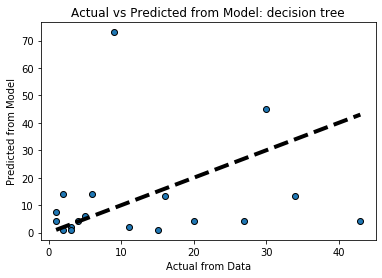

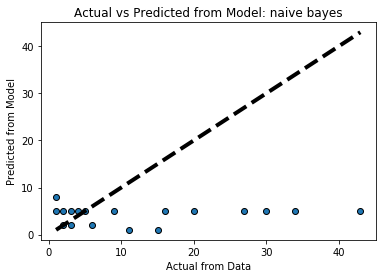

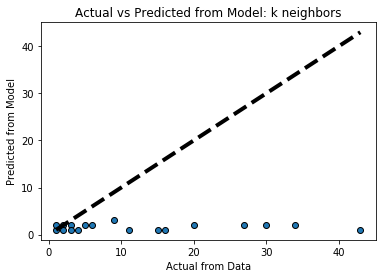

In [33]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    fifa_wc_winners_and_country_happiness,
    # target_column= #
    'num_wins', 
    # classified_column= #
    ['country'],
    # test_set_size= #
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    # data set name = #
    'fifa_wc_winners_and_country_happiness',)
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test)
PlotRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

Accuracy: 2.52%
Accuracy: 7.83%


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 11.47%


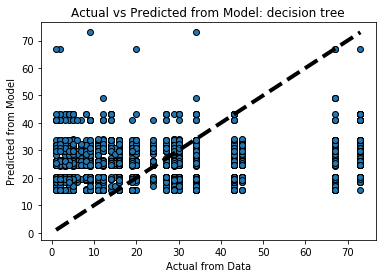

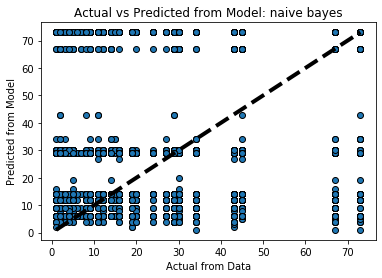

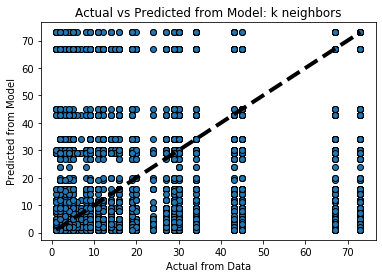

In [34]:
players_alltime_country_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
players_alltime_country_wins = players_alltime_country_wins.drop(['winner'], axis=1)
players_alltime_country_wins = players_alltime_country_wins.rename(columns={"num_wins": "wc_wins_for_country"})
x_train, x_test, y_train, y_test = setUpDataForClassification(
    players_alltime_country_wins, 
    # target_column= #
    'wc_wins_for_country', 
    # classified_columns= #
    ['nationality', 'full_name'],
    # test_set_size= #
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    # data set name = #
    'players_alltime_country_wins')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test)
PlotRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

Accuracy: 12.95%
Accuracy: 44.17%


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 48.13%


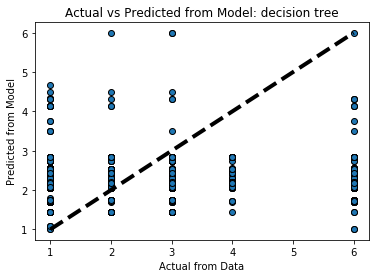

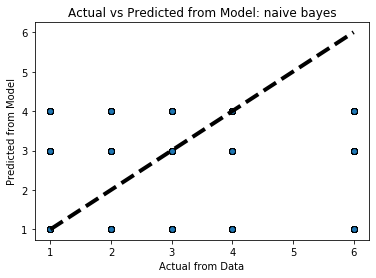

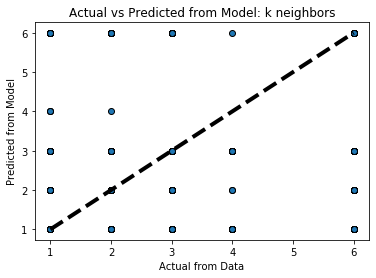

In [35]:
players_2018_wc_wins = pd.merge(left=fifa_wc_results_2018_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
players_2018_wc_wins = players_2018_wc_wins.drop(['winner'], axis=1)
players_2018_wc_wins = players_2018_wc_wins.rename(columns={"num_wins": "wc_wins_in_2018"})
x_train, x_test, y_train, y_test = setUpDataForClassification(
    players_2018_wc_wins,
    # target_column= #
    'wc_wins_in_2018', 
    # classified_columns= #
    ['nationality', 'full_name'],
    # test_set_size= #
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    # data set name = #
    'players_2018_wc_wins')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
y_test_kn, y_predicted_kn = KNeighbors(x_train, x_test, y_train, y_test)
PlotRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')
PlotRegressionFit(y_test_kn, y_predicted_kn, 'k neighbors')

